In [1]:
#numpy is for dealing with numpy arrays
import numpy as np

#pandas is for Data preprocessing 
import pandas as pd

#tensorflow mainly used for deep learning, neural networks, and natural language processing.
import tensorflow as tf

#Os to deal with OS functions
import os

# Use the Keras API directly through TensorFlow for trining deep learning model
from tensorflow import keras

#import statement that allows you to access the layers module
from tensorflow.keras import layers

#matplotlib.pyplot for visulization
import matplotlib.pyplot as plt

import random
#  used to load images
from PIL import Image
# for visualization
import matplotlib.image as mpimg

#Python import statement that allows you to access the Sequential class from the Keras API within TensorFlow.
from tensorflow.keras.models import Sequential

# importing pre_trained deep learning models
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet

# First look at the categories of my image dataset 

Lets show the first 6 categories

In [2]:
# Path to the folder containing class folders
dataset_path = r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\dataset\image data\train'

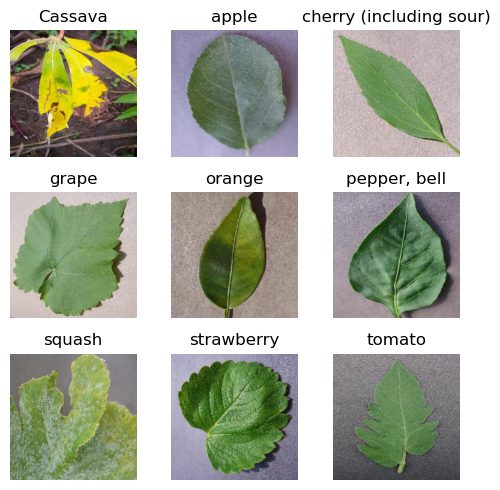

In [3]:
# Get the list of class folders
class_folders = sorted(os.listdir(dataset_path))

# Create a grid to display images i have 9 classes of leafs so 3x3
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for i, class_folder in enumerate(class_folders):
    # Get the list of images in the class folder
    class_path = os.path.join(dataset_path, class_folder)
    images = os.listdir(class_path)

    # Select the first image in the class (you can customize this)
    image_path = os.path.join(class_path, images[0])

    # Read and display the image using PIL
    image = Image.open(image_path)

    # Plot the image on the grid
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image)
    axes[row, col].set_title(class_folder)
    axes[row, col].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


# **Preparing Image Dataset**

In [4]:
# we are using the `Image_dataset_from_directory` function from the `tf.keras.utils` 
# module to create a TensorFlow dataset from image files stored in a directory

batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\dataset\image data\train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1837 files belonging to 9 classes.
Using 1470 files for training.


In [5]:
# The code block below is similar to the previous one, but we are creating a separate dataset for validation images.
val_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\dataset\image data\train',
  validation_split=0.2,
  subset="validation",
  seed=333,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1837 files belonging to 9 classes.
Using 367 files for validation.


In [6]:
# In this code block, we are accessing the class_names attribute of the train_ds dataset to get a list of the class names
class_names = train_ds.class_names

print(class_names)

['Cassava', 'apple', 'cherry (including sour)', 'grape', 'orange', 'pepper, bell', 'squash', 'strawberry', 'tomato']


In [7]:
# In the code block below, we are looping through the train_ds dataset and printing out the shapes of the image and label batches.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [8]:
# This operation caches the data in memory after it's been loaded from disk. 
# This can speed up training by avoiding the need to re-read the data from disk on each epoch.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Normalizing data into [0,1]
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9443349


In [11]:
# DATA Augmentation used to increase your dataset when you have small amount of data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# **Training a CNN Model**

In [54]:
# Now i'm creating the Architecture of my CNN model
# The model starts with a `data_augmentation` layer, which i had defined earlier to perform data augmentation
# on the input images. The next layer is a `Rescaling` layer, which scales the pixel values of the input images between 0 and 1. 
# Then contains three sets of convolutional, pooling layers, and dropout layer that randomly drops 20% of the input units 
# to prevent overfitting.
# CNN use a 3x3 filter and the activation function is relu which is mostly used becasue of sigmoid have vanishing problem

num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
# Flatten convert 2d layer into 1d
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [55]:
# Compile method of CNN model which uses Adam optimizer and SparseCategoricalCrossentropy loss function which is used for
# categorical dataset.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
#  Shows the summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [57]:
# Fit CNN model with 15 epochs only
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
46/46 [==============================] - 26s 550ms/step - loss: 1.9982 - accuracy: 0.3619 - val_loss: 1.4217 - val_accuracy: 0.5559
Epoch 2/15
46/46 [==============================] - 25s 549ms/step - loss: 0.9152 - accuracy: 0.6932 - val_loss: 0.5925 - val_accuracy: 0.8202
Epoch 3/15
46/46 [==============================] - 25s 550ms/step - loss: 0.5701 - accuracy: 0.8075 - val_loss: 0.6827 - val_accuracy: 0.7738
Epoch 4/15
46/46 [==============================] - 25s 549ms/step - loss: 0.4162 - accuracy: 0.8619 - val_loss: 0.6710 - val_accuracy: 0.7820
Epoch 5/15
46/46 [==============================] - 26s 563ms/step - loss: 0.4036 - accuracy: 0.8626 - val_loss: 0.2273 - val_accuracy: 0.9264
Epoch 6/15
46/46 [==============================] - 25s 551ms/step - loss: 0.3123 - accuracy: 0.8986 - val_loss: 0.1738 - val_accuracy: 0.9510
Epoch 7/15
46/46 [==============================] - 26s 556ms/step - loss: 0.2023 - accuracy: 0.9347 - val_loss: 0.3419 - val_accuracy: 0.8992

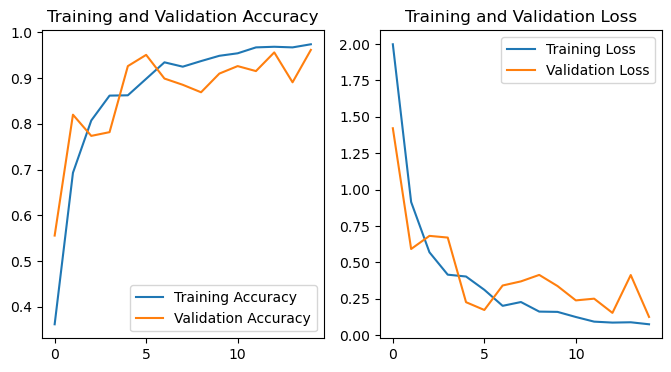

In [58]:
# Plot the graph of CNN model training accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
# Lets test our model on different pictures

img = tf.keras.utils.load_img(
    r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Projects\Plant Leaf classification project\dataset\image data\test\apple\2b21526f-9ab0-444b-829a-fa97cd727733___RS_HL 7844.JPG', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 86ms/step
This image most likely belongs to apple with a 99.83 percent confidence.


In [60]:
#Saving model
model.save('CNN_Model.h5')

# Transfer Learning Model

Now i'm training pre_trained models of tensorflow. Tensorflow have many diffrerent pre_trained models but i'm using only VGG16, ResNet50, MobiNet model and lets check the models performance adn compare with my CNN model.

# VGG16

In [11]:
#Importing layers
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

# importing pre-trained models
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet

#importing VGG16 Prepocess input
from keras.applications.vgg16 import preprocess_input

#Keras Preprocessing to process with the image
from keras.preprocessing import image

#Importing ImageDataGenerator to generate new images
from keras.preprocessing.image import ImageDataGenerator

#Importing Squential model
from keras.models import Sequential


In [13]:
# re-size all the images to the size [224,224]
IMAGE_SIZE = [224, 224]

#Images path
train_path = train_ds
valid_path = val_ds

In [26]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [27]:
# i use this line of code becasue i don't want to re-trained the weights of VGG
for layer in vgg.layers:
  layer.trainable = False

In [28]:
folders = class_names

In [29]:
#  Adding more layers for VGG16 model
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [30]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# fit the model
r = model.fit_generator(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)


Epoch 1/5


C:\Users\Muhammad Ahsan\AppData\Local\Temp\ipykernel_97220\2182865234.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(
C:\Users\Muhammad Ahsan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 151s 3s/step - loss: 1.8162 - accuracy: 0.9041 - val_loss: 0.0988 - val_accuracy: 0.9946
Epoch 2/5
46/46 [==============================] - 136s 3s/step - loss: 0.0200 - accuracy: 0.9980 - val_loss: 1.6925e-05 - val_accuracy: 1.0000
Epoch 3/5
46/46 [==============================] - 138s 3s/step - loss: 0.0356 - accuracy: 0.9952 - val_loss: 0.1179 - val_accuracy: 0.9918
Epoch 4/5
46/46 [==============================] - 138s 3s/step - loss: 0.0500 - accuracy: 0.9959 - val_loss: 0.0866 - val_accuracy: 0.9973
Epoch 5/5
46/46 [==============================] - 135s 3s/step - loss: 0.1440 - accuracy: 0.9884 - val_loss: 0.0063 - val_accuracy: 0.9973


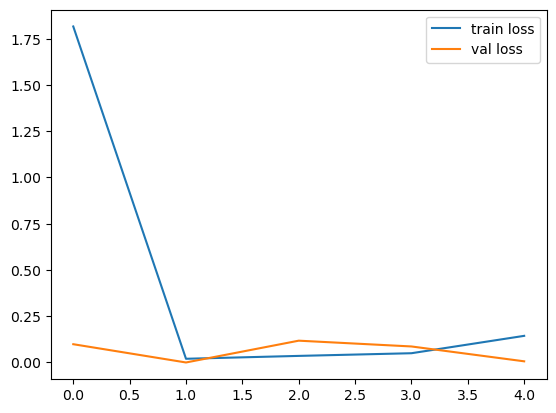

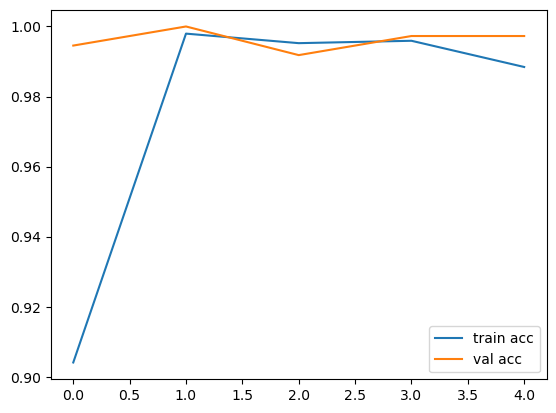

<Figure size 640x480 with 0 Axes>

In [33]:
# Plot the graph of BGG16 model performance
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
# Saving the model
model.save('VGG16_Model.h5')

In [34]:
# Lets test the VGG16 model with different picture
img = tf.keras.utils.load_img(
    r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\Dataset\image data\test\Cassava\2325593465.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 526ms/step
This image most likely belongs to Cassava


# ResNet50

In [14]:
# Add preprocessing layer to the front of ResNet50
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [15]:
# Not re-trained the weights of ResNet model
for layer in resnet.layers:
  layer.trainable = False

In [16]:
# extract the classes name
folders = class_names

In [17]:
# Adding more layers
x = Flatten()(resnet.output)
x = Dense(200, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


In [18]:
# create model object
resnet_model = Model(inputs=resnet.input, outputs=prediction)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [19]:
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# fit the model
r = resnet_model.fit_generator(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)

Epoch 1/5


C:\Users\Muhammad Ahsan\AppData\Local\Temp\ipykernel_136948\2873189060.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = resnet_model.fit_generator(
C:\Users\Muhammad Ahsan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 100s 2s/step - loss: 10.0609 - accuracy: 0.8755 - val_loss: 0.1643 - val_accuracy: 0.9918
Epoch 2/5
46/46 [==============================] - 97s 2s/step - loss: 0.1642 - accuracy: 0.9946 - val_loss: 0.1819 - val_accuracy: 0.9946
Epoch 3/5
46/46 [==============================] - 98s 2s/step - loss: 0.1871 - accuracy: 0.9939 - val_loss: 0.0420 - val_accuracy: 0.9973
Epoch 4/5
46/46 [==============================] - 97s 2s/step - loss: 0.0502 - accuracy: 0.9973 - val_loss: 0.1632 - val_accuracy: 0.9973
Epoch 5/5
46/46 [==============================] - 97s 2s/step - loss: 0.1201 - accuracy: 0.9952 - val_loss: 0.2285 - val_accuracy: 0.9946


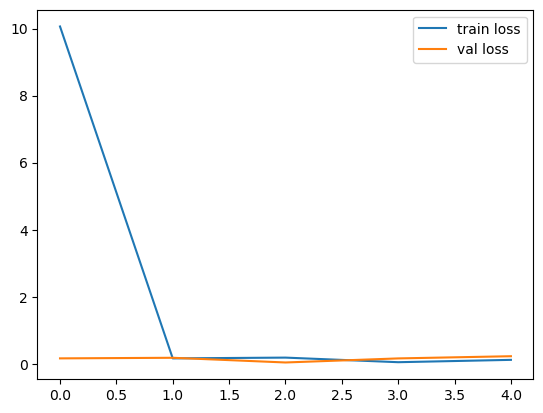

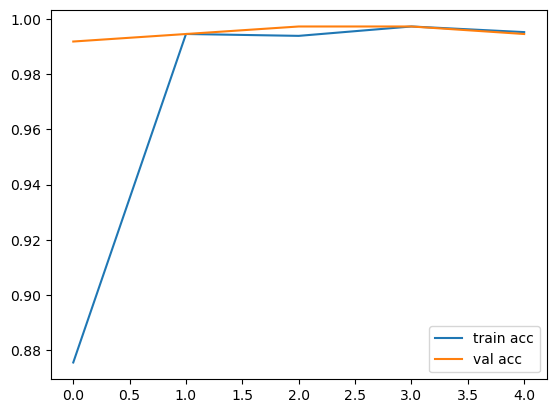

<Figure size 640x480 with 0 Axes>

In [21]:
# Graph of performance
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
#Saving model
resnet_model.save('Resnet50_Model.h5')

In [25]:
# Tesitng the model
img = tf.keras.utils.load_img(
    r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\Dataset\image data\test\Cassava\2325593465.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to Cassava


# MobiNet

In [26]:
# Add layer to the front of Mobinet
mobinet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 1s 0us/step


In [27]:
# Not re-trained the weights of MobiNet model
for layer in mobinet.layers:
  layer.trainable = False

In [28]:
# extract the classes name
folders = class_names

In [29]:
# Adding more layers
x = Flatten()(mobinet.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [30]:
# creating a model object
mobinet_model = Model(inputs=mobinet.input, outputs=prediction)
mobinet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [31]:
# compiling
mobinet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# fit the model
m = mobinet_model.fit_generator(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)

Epoch 1/5


C:\Users\Muhammad Ahsan\AppData\Local\Temp\ipykernel_136948\2156535568.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m = mobinet_model.fit_generator(


46/46 [==============================] - 33s 679ms/step - loss: 20.1415 - accuracy: 0.6830 - val_loss: 0.6916 - val_accuracy: 0.9128
Epoch 2/5
46/46 [==============================] - 31s 669ms/step - loss: 0.2467 - accuracy: 0.9714 - val_loss: 0.1344 - val_accuracy: 0.9837
Epoch 3/5
46/46 [==============================] - 31s 675ms/step - loss: 0.0870 - accuracy: 0.9837 - val_loss: 0.0389 - val_accuracy: 0.9946
Epoch 4/5
46/46 [==============================] - 31s 672ms/step - loss: 0.0394 - accuracy: 0.9932 - val_loss: 0.2120 - val_accuracy: 0.9728
Epoch 5/5
46/46 [==============================] - 31s 674ms/step - loss: 0.0396 - accuracy: 0.9946 - val_loss: 0.0813 - val_accuracy: 0.9864


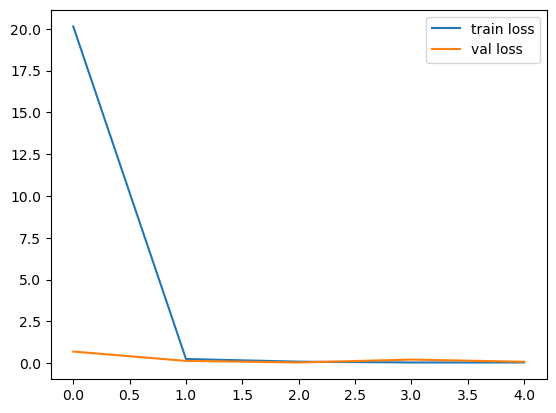

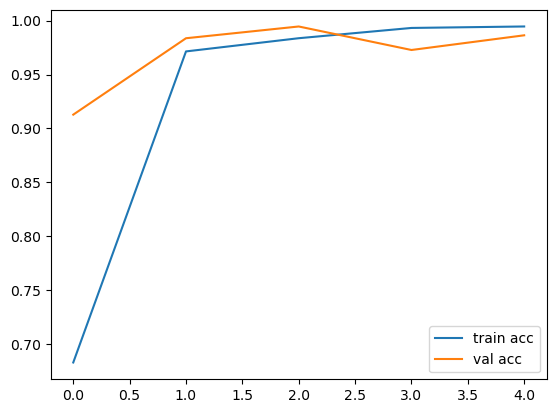

<Figure size 640x480 with 0 Axes>

In [33]:
# Graph of performance
plt.plot(m.history['loss'], label='train loss')
plt.plot(m.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(m.history['accuracy'], label='train acc')
plt.plot(m.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [34]:
#Saving model
mobinet_model.save('MobiNet_Model.h5')

In [36]:
#  Testing model on different picture
img = tf.keras.utils.load_img(
    r'C:\Users\Muhammad Ahsan\Desktop\CCT jupyter\Assessments\Plant_Leaf_Classification\Dataset\image data\test\pepper, bell\1f66bf0a-3af3-4084-ab73-c1e1b8f3dc46___JR_HL 8824.JPG', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 0s 147ms/step
This image most likely belongs to pepper, bell


# Lets Compare the models accuracy and loss

In [13]:
from tensorflow.keras.models import load_model

# Load the saved models
CNN_model = tf.keras.models.load_model('CNN_Model.h5')
VGG16_model = load_model('VGG16_Model.h5')
MobiNet_model = load_model('MobiNet_Model.h5')
Resnet_model = load_model('Resnet50_Model.h5')

In [14]:
#Evaluating all model accuracy

test_CNN_loss, test_CNN_acc = CNN_model.evaluate(val_ds)
test_VGG16_loss, test_VGG16_acc = VGG16_model.evaluate(val_ds)
test_mobi_loss, test_mobi_acc = MobiNet_model.evaluate(val_ds)
test_resnet_loss, test_resnet_acc = Resnet_model.evaluate(val_ds)

12/12 [==============================] - 4s 126ms/step - loss: 0.1261 - accuracy: 0.9619


C:\Users\Muhammad Ahsan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 21s 1s/step - loss: 0.2285 - accuracy: 0.9946


In [17]:
#Saving them into dictionary and converting them into dataframe for easy access
dic = {
    'Model':['CNN Model', 'VGG16_Model', 'MobiNet_Model','Resnet50_Model'],
    'Loss':[test_CNN_loss,test_VGG16_loss,test_mobi_loss,test_resnet_loss],
    'Accuracy':[test_CNN_acc,test_VGG16_acc,test_mobi_acc,test_resnet_acc]
}

df = pd.DataFrame(dic)

In [18]:
df

,Model,Loss,Accuracy
0,CNN Model,0.126124,0.961853
1,VGG16_Model,0.006278,0.997275
2,MobiNet_Model,0.081316,0.986376
3,Resnet50_Model,0.228522,0.994550


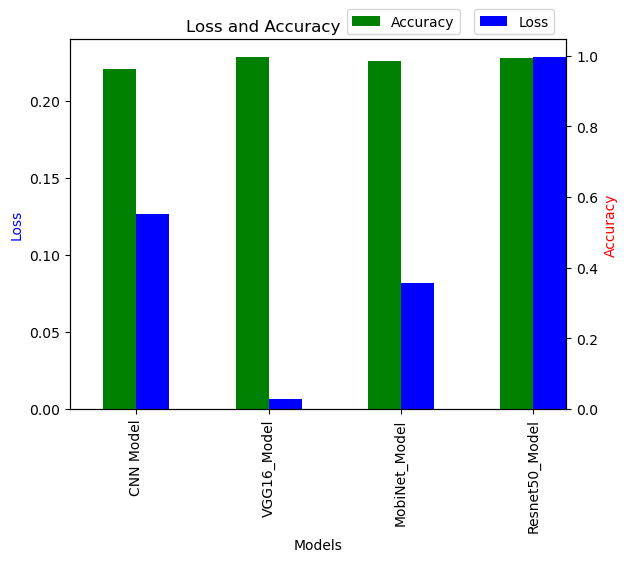

In [39]:
# Plotting
fig, ax1 = plt.subplots()
bar_width = 0.25
df.plot(kind='bar', x='Model', y='Loss', color='b', ax=ax1, position=0, width=bar_width)
# Set up a second y-axis to share the same x-axis
ax2 = ax1.twinx()
df.plot(kind='bar', x='Model', y='Accuracy', color='g', ax=ax2, position=1, width=bar_width)
ax1.set_xlabel('Models')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Accuracy', color='r')
plt.title('Loss and Accuracy                     ')

ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1.1))
plt.show()

In [19]:
# Find highest accuracy model
filt = (df['Accuracy'] == df['Accuracy'].max() )

df.loc[filt]

,Model,Loss,Accuracy
1,VGG16_Model,0.006278,0.997275


# Predicting First five images from the validation Dataset by CNN Model

In [43]:
# Get the first batch of images from the validation dataset
images, labels = next(iter(val_ds.take(1)))
# Select the first five images from the batch
images = images[:5]

# Predict the class probabilities of the first five images using the CNN model
CNN_model_predictions = CNN_model.predict(images)

# Get the predicted class index of each image
CNN_model_predicted_class_indices = np.argmax(CNN_model_predictions, axis=-1)

# Print the predicted class indices
print(CNN_model_predicted_class_indices)


1/1 [==============================] - 0s 113ms/step
[2 1 1 1 4]


Lets check model predicts the actual label or not

In [44]:
# Get the first batch of images and labels from the validation dataset
_, labels = next(iter(val_ds.take(1)))

# Select the first five labels from the batch
actual_class_indices = labels[:5]

# Print the actual class indices
print(actual_class_indices)


tf.Tensor([2 1 1 8 4], shape=(5,), dtype=int32)


In [48]:
# Predict the class probabilities of the first five images 
CNN_model_predictions = CNN_model.predict(images)
VGG16_model_predictions = VGG16_model.predict(images)
Resnet50_Model_predictions = Resnet_model.predict(images)
MobiNet_Model_predictions = MobiNet_model.predict(images)

# Get the predicted class index of each image
CNN_model_predicted_class_indices = np.argmax(CNN_model_predictions, axis=-1)
VGG16_model_predicted_class_indices = np.argmax(VGG16_model_predictions, axis=-1)
Resnet50_model_predicted_class_indices = np.argmax(Resnet50_Model_predictions, axis=-1)
MobiNet_model_predicted_class_indices = np.argmax(MobiNet_Model_predictions, axis=-1)

# Print the predicted class indices
print(CNN_model_predicted_class_indices)
print(VGG16_model_predicted_class_indices)
print(Resnet50_model_predicted_class_indices)
print(MobiNet_model_predicted_class_indices)



1/1 [==============================] - 0s 100ms/step
[2 1 1 1 4]
[2 1 1 8 4]
[2 1 1 8 4]
[2 2 1 8 4]


In [49]:
#Saving them into dic and converting them into dataframe for better results
dic1 = {
    'Actutal_Class':actual_class_indices,
    'CNN_Model_predicted':CNN_model_predicted_class_indices,
    'VGG16_Model_predicted':VGG16_model_predicted_class_indices,
    'Resnet50_Model_predicted':Resnet50_model_predicted_class_indices,
    'MobiNet_Model_predicted':MobiNet_model_predicted_class_indices
}

results = pd.DataFrame(dic1)

In [50]:
results

,Actutal_Class,CNN_Model_predicted,VGG16_Model_predicted,Resnet50_Model_predicted,MobiNet_Model_predicted
0,2,2,2,2,2
1,1,1,1,1,2
2,1,1,1,1,1
3,8,1,8,8,8
4,4,4,4,4,4


As you can see that CNN model did only one wrong prediction t and the other models did the accurate.  